- set up git (add your name and email once) and pull the repo

In [1]:
# change wd to team working directory
import os
os.chdir('/scratch/ws/gpu16-d3hack2019-DeepHydro/')
#!git config --global user.name "Lennart Schmidt"
#!git config --global user.email "lennart.schmidt@ufz.de"
#!git pull
#!hostname

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import numpy as np
import os, sys
import pandas as pd

Using TensorFlow backend.


In [3]:
!pwd

/lustre/scratch2/ws/gpu16-d3hack2019-DeepHydro


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import numpy as np
import os, sys
import pandas as pd
from skimage.external import tifffile
import skimage
skimage.__version__

'0.14.1'

In [5]:
#data_folder = 'Data/Rawtiff/'
#data_prec = '01_prec_rawtiff.tif'
#data_temp = '01_temp_rawtiff.tif'
#data_elev = '01_dem_rawtiff.tif'
#data_disc = '01_discharge.csv'


data_folder = './Data/Npy'
fn_prec = '01_prec_training.npy'
fn_temp = '01_temp_training.npy'
fn_mask = '01_mask.npy'
#data_elev = 'Npy/01_dem.npy'
fn_disc = '01_discharge_training.csv'

- import **deephydro module** with networks, losses and metrics

In [6]:
%load_ext autoreload
%autoreload 2
module_folder = os.path.abspath('./src')
#module_folder = 'src/'
if module_folder not in sys.path:
    sys.path.append(module_folder)
import deephydro

#from deephydro.utils import limit_gpu_memory
#limit_gpu_memory()

# Data import

- read output data

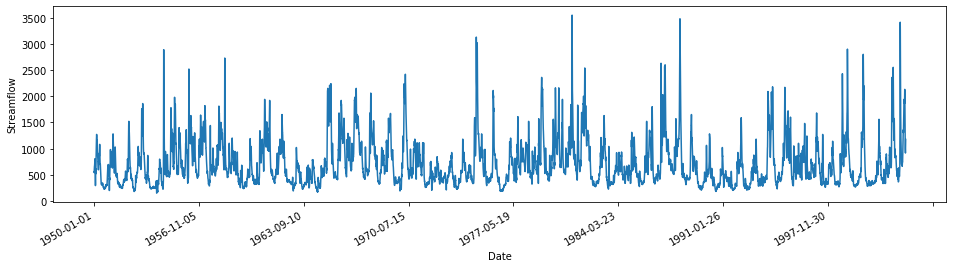

In [7]:
from deephydro import data, visualization
df = data.load_csv_data(data_folder=data_folder, filename=fn_disc)

visualization.plot_streamflow(df=df)

In [8]:
df.tail()

Unnamed: 0        Time         Q  DOY  DiffToMidSummer      FDOY
19353       46808  2002-12-27   975.286  361         0.989041  0.986339
19354       46809  2002-12-28  1031.810  362         0.991781  0.989071
19355       46810  2002-12-29  1081.370  363         0.994521  0.991803
19356       46811  2002-12-30  1131.740  364         0.997260  0.994536
19357       46812  2002-12-31  1174.110  365         1.000000  0.997268

### Load data directly as .npy files

In [9]:
x_prec = data.load_from_numpy(data_folder, filename=fn_prec)
x_temp = data.load_from_numpy(data_folder, filename=fn_temp)
x_mask = data.load_from_numpy(data_folder, filename=fn_mask)

In [10]:
print(f'x_prec.shape = {x_prec.shape}')
print(f'x_temp.shape = {x_temp.shape}')
print(f'x_mask.shape = {x_mask.shape}')

x_prec.shape = (19358, 53, 66)
x_temp.shape = (19358, 53, 66)
x_mask.shape = (53, 66)


In [11]:
x_prec[:, x_mask == True] = np.nan
x_temp[:, x_mask == True] = np.nan

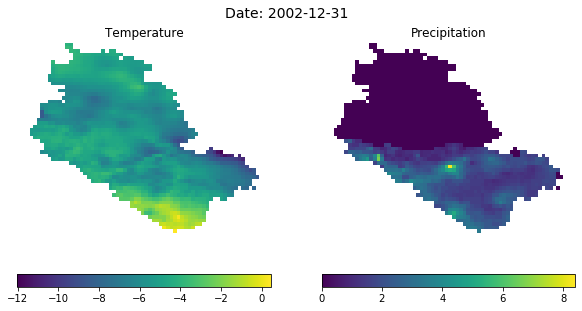

In [12]:
visualization.plot_temp_prec_frame(x_temp, x_prec, x_mask, df, frame=-1)

In [13]:
mean_temp = []
mean_prec = []
for i in range(x_temp.shape[0]):
    mean_temp.append(np.nanmean(x_temp[i]))
    mean_prec.append(np.nanmean(x_prec[i]))

df["mean_prec"] = mean_prec
df["mean_temp"] = mean_temp

In [14]:
df.tail()

Unnamed: 0        Time         Q  DOY  DiffToMidSummer      FDOY  \
19353       46808  2002-12-27   975.286  361         0.989041  0.986339   
19354       46809  2002-12-28  1031.810  362         0.991781  0.989071   
19355       46810  2002-12-29  1081.370  363         0.994521  0.991803   
19356       46811  2002-12-30  1131.740  364         0.997260  0.994536   
19357       46812  2002-12-31  1174.110  365         1.000000  0.997268   

       mean_prec  mean_temp  
19353   0.614431   0.610334  
19354   1.243649   1.717662  
19355  10.186704   3.754925  
19356  14.087836   3.125038  
19357   0.977162  -5.226691

In [15]:
x = df[["mean_prec", "mean_temp"]]
y = df.Q
time_axis = df.Time

## Data Preparation

- split train and validation data

In [16]:
# split train and validation data
validation_fraction = 0.2
validation_first = False


val_size = int(validation_fraction * x.shape[0])
train_size = x.shape[0] - val_size

if validation_first:
    x_train, x_val = x[val_size:], x[:val_size]
    y_train, y_val = y[val_size:], y[:val_size]
    time_axis_train, time_axis_val  = time_axis[val_size:], time_axis[:val_size]
    
else:
    x_train, x_val = x[:train_size], x[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]
    time_axis_train, time_axis_val = time_axis[:train_size], time_axis[train_size:]


In [17]:
print('Shape of x_train = ', x_train.shape)
print('Shape of y_train = ', y_train.shape)
print('Shape of x_val   = ', x_val.shape)
print('Shape of y_val   = ', y_val.shape)

Shape of x_train =  (15487, 2)
Shape of y_train =  (15487,)
Shape of x_val   =  (3871, 2)
Shape of y_val   =  (3871,)


- standardize output data (`y`)

In [18]:
Y_MEAN, Y_STD = y_train.mean(skipna = True), y_train.std(skipna = True)

y_train = (y_train - Y_MEAN)/Y_STD
y_val   = (y_val -   Y_MEAN)/Y_STD

In [19]:
Y_STD

426.77607684637434

In [20]:
X_MEAN, X_STD = x_train.mean(skipna = True), x_train.std(skipna = True)
x_train = (x_train - X_MEAN)/X_STD
x_val = (x_val - X_MEAN)/X_STD

In [21]:
#y_train = y_train.replace([np.inf, -np.inf], np.nan)
#y_val = y_val.replace([np.inf, -np.inf], np.nan)


#x_train = x_train[~x_train.isin([np.nan, np.inf, -np.inf]).any(1)]
#x_val = x_val[~x_val.isin([np.nan, np.inf, -np.inf]).any(1)]

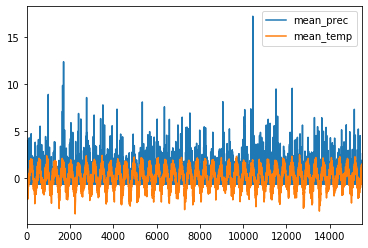

In [22]:
x_train.plot()

In [23]:
input_shape = x_train.shape
n_units = 80
n_layers = 3
n_frames = 70 # length of image sequence: how many days of data to predict streamflow?

In [24]:
from keras import layers, models
i = layers.Input(shape = (n_frames, 2)) # (?, n_frames, channels) 

# add the lstm layers
x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=True)(i) # (?, n_units)
#x = layers.BatchNormalization()(x)
n_units *= 2

x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=True)(x) # (?, n_units)
#x = layers.BatchNormalization()(x)
n_units *= 2

x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=True)(x) # (?, n_units)
#x = layers.BatchNormalization()(x)
n_units *= 2

x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=False)(x) # (?, n_units)
#x = layers.BatchNormalization()(x)
#n_units *= 2            

#x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Activation('relu')(x)

o = layers.Dense(1, activation = 'linear')(x)  

W0912 18:17:38.091547 35184372383840 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0912 18:17:38.105275 35184372383840 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0912 18:17:38.107578 35184372383840 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [25]:
model = models.Model(inputs=[i], outputs=[o])

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 70, 2)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70, 80)            26560     
_________________________________________________________________
lstm_2 (LSTM)                (None, 70, 160)           154240    
_________________________________________________________________
lstm_3 (LSTM)                (None, 70, 320)           615680    
_________________________________________________________________
lstm_4 (LSTM)                (None, 640)               2460160   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               82048     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
__________

In [27]:
from keras import optimizers, losses, metrics
    
model.compile(optimizer=optimizers.Adam(lr=1e-3),
              loss=losses.mse)
              #metrics=[metrics.mse])

W0912 18:17:39.843986 35184372383840 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [28]:
from keras import utils
class ImageSequenceGenerator(utils.Sequence):
    '''Generates image sequences'''

    def __init__(self, data, labels, batch_size=32, n_frames=5):
        '''Initialization'''
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.n_frames = n_frames

    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        '''Generate one batch of data'''

        batch_x, batch_y = [], []

        for _ in range(self.batch_size):
            # Get start index of sequence
            start_index = np.random.randint(0, len(self.data) - self.n_frames)
            stop_index = start_index + self.n_frames

            # x = image sequence
            x = self.data[start_index:stop_index].values
            # y = streamflow at end point
            y = self.labels[stop_index]
            batch_x.append(x)
            batch_y.append(y)

        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)

        return batch_x, batch_y

In [29]:
n_epochs = 20
batch_size = 240

generator_train = ImageSequenceGenerator(data = x_train, labels = y_train, batch_size = batch_size, n_frames = n_frames)
generator_test  = ImageSequenceGenerator(data = x_val, labels = y_val.values, batch_size = batch_size, n_frames = n_frames)


batch = generator_train.__getitem__(0)
print(f'Shape of batch_x = {batch[0].shape}')
print(f'Shape of batch_y = {batch[1].shape}')

Shape of batch_x = (240, 70, 2)
Shape of batch_y = (240,)


In [30]:
batch = generator_test.__getitem__(0)
print(f'Shape of batch_x = {batch[0].shape}')
print(f'Shape of batch_y = {batch[1].shape}')

Shape of batch_x = (240, 70, 2)
Shape of batch_y = (240,)


In [31]:
x_val.shape

(3871, 2)

In [32]:
history = model.fit_generator(generator = generator_train,
                              steps_per_epoch = len(x_train)//batch_size,
                              epochs = n_epochs,
                              validation_data = generator_test,
                              validation_steps = len(x_val)//batch_size)

W0912 18:17:40.459354 35184372383840 deprecation.py:323] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0912 18:17:42.760551 35184372383840 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0912 18:17:42.964396 35184372383840 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/20
64/64 [==============================] - 48s 743ms/step - loss: 0.5917 - val_loss: 0.7171
Epoch 2/20
64/64 [==============================] - 40s 626ms/step - loss: 0.3909 - val_loss: 0.2937
Epoch 3/20
64/64 [==============================] - 41s 640ms/step - loss: 0.2637 - val_loss: 0.3084
Epoch 4/20
64/64 [==============================] - 40s 632ms/step - loss: 0.2291 - val_loss: 0.2598
Epoch 5/20
64/64 [==============================] - 40s 630ms/step - loss: 0.2231 - val_loss: 0.2988
Epoch 6/20
64/64 [==============================] - 41s 643ms/step - loss: 0.2204 - val_loss: 0.2788
Epoch 7/20
64/64 [==============================] - 42s 649ms/step - loss: 0.1999 - val_loss: 0.3102
Epoch 8/20
64/64 [==============================] - 41s 640ms/step - loss: 0.1858 - val_loss: 0.3168
Epoch 9/20
64/64 [==============================] - 40s 625ms/step - loss: 0.1801 - val_loss: 0.2469
Epoch 10/20
64/64 [==============================] - 41s 634ms/step - loss: 0.1844 - val_lo

In [ ]:
historz

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

NameError: name 'history' is not defined

In [7]:
history

# change wd to team working directory
import os
os.chdir('/scratch/ws/gpu16-d3hack2019-DeepHydro/')
#!git config --global user.name "Lennart Schmidt"
#!git config --global user.email "lennart.schmidt@ufz.de"
#!git pull
#!hostname
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import numpy as np
import os, sys
import pandas as pd
!pwd
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
history.history
history
history


# Predict

In [34]:
from deephydro.utils import predict
batch = generator_test.__getitem__(0)
im = batch[0][0]
#gt = batch[1][0] * Y_STD + Y_MEAN
gt = batch[1][0]
y_pred = predict(model, image=im)
print(f'Predicted: {y_pred:.2f}, True: {gt:.2f}, Error: {abs(y_pred-gt):.2f}')

Predicted: 0.19, True: 0.66, Error: 0.47


In [ ]:
from deephydro.utils import predict_batch
x, y = predict_batch(model, generator=generator_test, n_samples=5000)

(5000,)
(5000,)
(5000,)
(5000,)


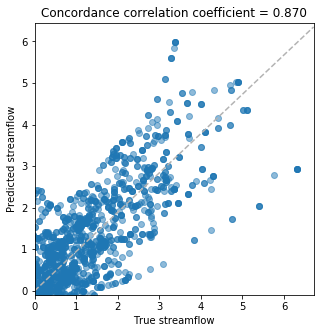

In [36]:
from deephydro.visualization import plot_correlation
plot_correlation(x, y)

In [104]:
predictions = []
for t in range(0, len(x_val)-n_frames):
    data = x_val[t:t+n_frames].values
    data = data[np.newaxis, ...]
    p = model.predict( data )
    predictions.append(p)

KeyboardInterrupt: 

In [83]:

flat_list = [item for sublist in predictions for item in sublist]

flat_list = [item for sublist in flat_list for item in sublist]


In [116]:
batch_size

(148,)

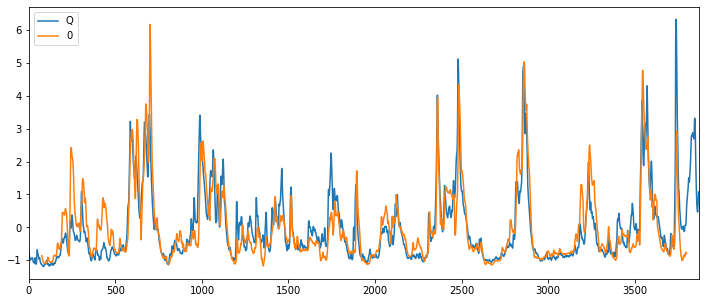

In [118]:
pd.concat([y_val.reset_index(drop = True), pd.DataFrame(flat_list).shift(periods=74)], axis = 1).plot(figsize=(12,5))

#plt.plot(flat_list)

In [113]:
pd.concat([y_val.reset_index(drop = True), pd.DataFrame(flat_list).shift(periods=10)], axis = 1)

Q         0
0    -0.746146       NaN
1    -0.818784       NaN
2    -0.851588       NaN
3    -0.884392       NaN
4    -0.914853       NaN
5    -0.933598       NaN
6    -0.957030       NaN
7    -0.987491       NaN
8    -0.994520       NaN
9    -1.001549       NaN
10   -0.989834 -0.860182
11   -0.982804 -0.879878
12   -0.961716 -0.900529
13   -0.945314 -0.922265
14   -0.945314 -0.947884
15   -0.945314 -0.978071
16   -0.947657 -1.002418
17   -0.940628 -1.021900
18   -0.926569 -1.045025
19   -0.924226 -1.061191
20   -0.924226 -1.071252
21   -0.940628 -1.076369
22   -0.966402 -1.079714
23   -1.001549 -1.078356
24   -1.039040 -1.079375
25   -1.060128 -1.082367
26   -1.062471 -1.083176
27   -1.064814 -1.086226
28   -1.053099 -1.089097
29   -1.060128 -1.090184
...        ...       ...
3841  2.794891       NaN
3842  2.734204       NaN
3843  2.687013       NaN
3844  2.751449       NaN
3845  2.933934       NaN
3846  3.139615       NaN
3847  3.274604       NaN
3848  3.317460       NaN
3849  3.260217       NaN
3850  3.125486       NaN
3851  2.915540       NaN
3852  2.645937       NaN
3853  2.378139       NaN
3854  2.045880       NaN
3855  1.697430       NaN
3856  1.390923       NaN
3857  1.219686       NaN
3858  1.035795       NaN
3859  0.805909       NaN
3860  0.691352       NaN
3861  0.615615       NaN
3862  0.549299       NaN
3863  0.499238       NaN
3864  0.466141       NaN
3865  0.481566       NaN
3866  0.608864       NaN
3867  0.741308       NaN
3868  0.857435       NaN
3869  0.975459       NaN
3870  1.074738       NaN

[3871 rows x 2 columns]

In [67]:
from deephydro.utils import predict_timeseries
#df_val = x_val.append(y_val)
maxtime = 200 #len(x_val)
ts_pred, ts_gt, df_pred = predict_timeseries(model=model, 
                                    data = pd.concat([x_val, y_val, time_axis_val], axis=1), 
                                    doy=None, 
                                    df=x_val[:maxtime],
                                    n_frames=n_frames, 
                                    stride=1, 
                                    batch_size = 140, 
                                    Y_MEAN = Y_MEAN, Y_STD = Y_STD,
                                    gt=y_val[:maxtime], 
                                    plot=True,
                                    uncertainty=False)

0 / 3801


ValueError: cannot copy sequence with size 70 to array axis with dimension 4

In [68]:
data =pd.concat([x_val, y_val, time_axis_val], axis=1)
doy = None
df = x_val[:maxtime],
#n_frames:int,
stride = 1
batch_size = 148,
#Y_MEAN:float=None, 
#Y_STD:float=None, 
gt = y_val[:maxtime] 
plot = True,
uncertainty = False,
T=10


predictions  = np.array([])
if uncertainty: uncertainties= np.array([])
ground_truth = np.array([])
n_samples = (len(data)-n_frames) // stride
index = 0

while len(predictions) < n_samples:
    print(f'{len(predictions)} / {n_samples}')

    # get a batch of inputs (largely overlapping)
    iterator = range(index, min(index+batch_size, n_samples), stride)
    batch = np.array([data[i : i+n_frames] for i in iterator])
    if doy is not None:
        batch_doy = np.array([doy[i+n_frames] for i in iterator])
    y_trues = np.array([gt[i+n_frames] for i in iterator])

    index += batch_size

    if doy is None:
        input_data = batch
    else:
        input_data = [batch, batch_doy]

    if uncertainty:
        y_preds, y_stds = predict_uncertainty(model, input_data, T=T)
    else:
        y_preds = np.squeeze(model.predict(input_data))

    # rescale prediction 
    with_rescaling = False
#             if Y_MEAN is not None and Y_STD is not None:
#                 with_rescaling = True

    if with_rescaling:
        y_preds = np.exp(y_preds * Y_STD + Y_MEAN)
        y_trues = np.exp(y_trues * Y_STD + Y_MEAN)
        if uncertainty: y_stds = np.exp(y_stds *  Y_STD) 

    predictions  = np.concatenate([predictions, y_preds])
    ground_truth = np.concatenate([ground_truth, y_trues])
    if uncertainty: uncertainties = np.concatenate([uncertainties, y_stds])




0 / 3801


TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

In [60]:
time_axis_train, time_axis_val  = time_axis[train_size:], time_axis[:train_size]

mean_prec  mean_temp         Q        Time
15487  -0.611634   1.049014 -0.746146  1992-05-27
15488  -0.643053   0.953188 -0.818784  1992-05-28
15489  -0.646148   0.958712 -0.851588  1992-05-29
15490  -0.649779   1.131945 -0.884392  1992-05-30
15491  -0.649779   1.320701 -0.914853  1992-05-31
15492  -0.618616   1.578458 -0.933598  1992-06-01
15493   0.011721   1.769203 -0.957030  1992-06-02
15494   3.634014   1.386460 -0.987491  1992-06-03
15495  -0.133342   1.295921 -0.994520  1992-06-04
15496  -0.229997   1.606051 -1.001549  1992-06-05
15497   2.255974   1.083665 -0.989834  1992-06-06
15498   0.079027   1.087430 -0.982804  1992-06-07
15499   1.574250   0.996672 -0.961716  1992-06-08
15500   0.703080   1.104484 -0.945314  1992-06-09
15501  -0.136368   0.807631 -0.945314  1992-06-10
15502   0.718091   0.572794 -0.945314  1992-06-11
15503  -0.302680   0.903315 -0.947657  1992-06-12
15504  -0.637491   1.245276 -0.940628  1992-06-13
15505  -0.649779   1.405566 -0.926569  1992-06-14
15506  -0.649779   1.554405 -0.924226  1992-06-15
15507  -0.364843   1.494722 -0.924226  1992-06-16
15508  -0.546957   1.189841 -0.940628  1992-06-17
15509   0.517265   1.058761 -0.966402  1992-06-18
15510  -0.429450   1.306842 -1.001549  1992-06-19
15511  -0.335076   1.639826 -1.039040  1992-06-20
15512  -0.605164   1.516469 -1.060128  1992-06-21
15513  -0.649779   1.292466 -1.062471  1992-06-22
15514   3.539571   1.383608 -1.064814  1992-06-23
15515  -0.117633   1.196311 -1.053099  1992-06-24
15516  -0.512629   1.311145 -1.060128  1992-06-25
...          ...        ...       ...         ...
19328  -0.580192  -0.586865  2.794891  2002-12-02
19329  -0.315573  -0.613528  2.734204  2002-12-03
19330  -0.448674  -0.660952  2.687013  2002-12-04
19331  -0.535553  -0.858689  2.751449  2002-12-05
19332  -0.573861  -1.188284  2.933934  2002-12-06
19333  -0.649779  -1.629130  3.139615  2002-12-07
19334  -0.649779  -1.852158  3.274604  2002-12-08
19335  -0.649779  -2.176650  3.317460  2002-12-09
19336  -0.649779  -2.258654  3.260217  2002-12-10
19337  -0.649779  -2.109470  3.125486  2002-12-11
19338  -0.649779  -2.030097  2.915540  2002-12-12
19339  -0.637328  -1.930301  2.645937  2002-12-13
19340  -0.649779  -1.661538  2.378139  2002-12-14
19341  -0.301749  -1.538472  2.045880  2002-12-15
19342   0.301498  -1.078785  1.697430  2002-12-16
19343  -0.058263  -1.038899  1.390923  2002-12-17
19344  -0.539463  -1.199241  1.219686  2002-12-18
19345  -0.649779  -1.291432  1.035795  2002-12-19
19346  -0.643961  -1.513669  0.805909  2002-12-20
19347  -0.594877  -1.113785  0.691352  2002-12-21
19348   3.752522  -1.104416  0.615615  2002-12-22
19349  -0.584264  -1.299943  0.549299  2002-12-23
19350  -0.123637  -1.472430  0.499238  2002-12-24
19351  -0.629531  -1.358199  0.466141  2002-12-25
19352  -0.040901  -1.222303  0.481566  2002-12-26
19353  -0.409970  -0.956018  0.608864  2002-12-27
19354  -0.164389  -0.810978  0.741308  2002-12-28
19355   3.326038  -0.544134  0.857435  2002-12-29
19356   4.848629  -0.626638  0.975459  2002-12-30
19357  -0.268398  -1.720561  1.074738  2002-12-31

[3871 rows x 4 columns]

In [53]:
#x_val.append(pd.DataFrame(y_val, columns=['Q']))
#x_val.append(pd.DataFrame(time_axis_val, columns=['Time']))

tmp_x_val = pd.concat(x_val, y_val, df. axis=1)
tmp_x_val.append(pd.DataFrame(y_val, columns=['Q']).reset_index(drop=True), ignore_index=True)

Q  mean_prec  mean_temp
0          NaN  -0.611634   1.049014
1          NaN  -0.643053   0.953188
2          NaN  -0.646148   0.958712
3          NaN  -0.649779   1.131945
4          NaN  -0.649779   1.320701
5          NaN  -0.618616   1.578458
6          NaN   0.011721   1.769203
7          NaN   3.634014   1.386460
8          NaN  -0.133342   1.295921
9          NaN  -0.229997   1.606051
10         NaN   2.255974   1.083665
11         NaN   0.079027   1.087430
12         NaN   1.574250   0.996672
13         NaN   0.703080   1.104484
14         NaN  -0.136368   0.807631
15         NaN   0.718091   0.572794
16         NaN  -0.302680   0.903315
17         NaN  -0.637491   1.245276
18         NaN  -0.649779   1.405566
19         NaN  -0.649779   1.554405
20         NaN  -0.364843   1.494722
21         NaN  -0.546957   1.189841
22         NaN   0.517265   1.058761
23         NaN  -0.429450   1.306842
24         NaN  -0.335076   1.639826
25         NaN  -0.605164   1.516469
26         NaN  -0.649779   1.292466
27         NaN   3.539571   1.383608
28         NaN  -0.117633   1.196311
29         NaN  -0.512629   1.311145
...        ...        ...        ...
7712  2.794891        NaN        NaN
7713  2.734204        NaN        NaN
7714  2.687013        NaN        NaN
7715  2.751449        NaN        NaN
7716  2.933934        NaN        NaN
7717  3.139615        NaN        NaN
7718  3.274604        NaN        NaN
7719  3.317460        NaN        NaN
7720  3.260217        NaN        NaN
7721  3.125486        NaN        NaN
7722  2.915540        NaN        NaN
7723  2.645937        NaN        NaN
7724  2.378139        NaN        NaN
7725  2.045880        NaN        NaN
7726  1.697430        NaN        NaN
7727  1.390923        NaN        NaN
7728  1.219686        NaN        NaN
7729  1.035795        NaN        NaN
7730  0.805909        NaN        NaN
7731  0.691352        NaN        NaN
7732  0.615615        NaN        NaN
7733  0.549299        NaN        NaN
7734  0.499238        NaN        NaN
7735  0.466141        NaN        NaN
7736  0.481566        NaN        NaN
7737  0.608864        NaN        NaN
7738  0.741308        NaN        NaN
7739  0.857435        NaN        NaN
7740  0.975459        NaN        NaN
7741  1.074738        NaN        NaN

[7742 rows x 3 columns]

In [ ]:
[x_val, pd.DataFrame(y_val, columns=['Q']),  pd.DataFrame(time_axis_val, columns=['Time'])]

In [ ]:
import pandas as pd            
df = pd.DataFrame({'Time':df['Time'][:-n_frames],
                    'Q':ground_truth,
                    'Q_pred':predictions})

In [ ]:
ground_truth

In [ ]:
plt.plot(x)
plt.plot(y)

In [ ]:
df_val =

In [ ]:
x_val.append(y_val)

# Saliency map

- using a variant of `DeepLIFT` called `DeepShap` based on Shapley values and implemented in the package [`shap`](https://github.com/slundberg/shap)


```
conda install -c conda-forge shap
pip install tqdm --upgrade # I needed to upgrade tqdm (progress bar)
```

In [ ]:
# get a batch of images
batch = generator_test.__getitem__(0)
# select a single image
im = batch[0][123]

In [ ]:
from deephydro.utils import saliency_map
shap = saliency_map(model, generator=generator_test, image=im)
print(shap.shape)

In [ ]:
from deephydro.visualization import plot_saliency_map
plot_saliency_map(image=im, shap_values=shap, mask=mask)